## Pasting

In [1]:
# Importamos las librerías necesarias

import numpy as np
import pandas as pd
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Representaciones graficas locales

%pylab
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

# Obviamos los errores de actualización 

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

# Ponemos la semilla
np.random.seed(0)

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Importamos la función de limpieza y preprocesado de datos
import frauddef # con solo las variables de research

In [3]:
# Importamos el dataset 
df = pd.read_csv('Explor_uscecchini28.csv')

In [4]:
# Establecemos las variables X e Y
X_train_nm, X_test_nm, y_train_nm, y_test_nm, X_train_sm, X_test_sm, y_train_sm, y_test_sm = frauddef.limpieza(df)

Using TensorFlow backend.


In [5]:
# ajustamos el parametro "n_components" que nos a indicar cuantos componentes necesitamos para explicar el 95 % de los datos
pca = PCA(n_components=0.95)

# hacemos la transofrmación del Train y Test
X_train_nm = pca.fit_transform(X_train_nm)
X_test_nm = pca.transform(X_test_nm)

# Selección del número de n_components
print("Number of PCA components: ", pca.n_components_)

Number of PCA components:  3


##### Random Forest Classifier with Pasting

In [6]:
# Selección del parámetro “max_depth” de RF con la función "GridSearchCV"
rf = RandomForestClassifier()

grid_param = dict(max_depth=[1,3,5,7,9,15], 
                  n_estimators= [100,250,500],criterion=['gini', 'entropy'])

rf_grid = GridSearchCV(rf, grid_param, cv = 2, n_jobs = -1)
rf_grid.fit(X_train_nm, y_train_nm)

GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 3, 5, 7, 9, 15],
                         'n_estimators': [100, 250, 500]})

In [7]:
print("Best Parameters for Random Forest Classifier: ", rf_grid.best_params_)

Best Parameters for Random Forest Classifier:  {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 100}


In [8]:
# Selección de los parámetros 'n_estimators' y 'learning_rate' de RF con la función "GridSearchCV"

rf = RandomForestClassifier(n_estimators= rf_grid.best_params_['n_estimators']
                                , max_depth= rf_grid.best_params_['max_depth']
                                ,criterion = rf_grid.best_params_['criterion'])


bag = BaggingClassifier(rf)
#model param
grid_param = dict() 

#grid model
bag_rf_grid = GridSearchCV(bag, grid_param, cv = 2, n_jobs = -1, return_train_score= True)

#train grid model
bag_rf_grid.fit(X_train_nm, y_train_nm)

GridSearchCV(cv=2,
             estimator=BaggingClassifier(base_estimator=RandomForestClassifier(max_depth=3)),
             n_jobs=-1, param_grid={}, return_train_score=True)

In [9]:
# Mejores parámetros
print("Best Parameters for Bagging Classifier with Pasting: ", bag_rf_grid.best_params_)

Best Parameters for Bagging Classifier with Pasting:  {}


In [11]:
# Construcción del modelo 

bag = BaggingClassifier(rf,bootstrap=False) # bootstrap=False Para Pasting
bag.fit(X_train_nm, y_train_nm)

BaggingClassifier(base_estimator=RandomForestClassifier(max_depth=3),
                  bootstrap=False)

Random Forest Classifier with Pasting Training Score:  0.9734513274336283
Random Forest Classifier with Pasting Testing Score:  0.9795918367346939
- Nombre del Modelo: RandomForestClassifier 
 
 - Precisión: 0.9795918367346939 | 
 - Exactitud: 1.0 | 
 - Exhaustividad: 0.9615384615384616 | 
 - F1: 0.9803921568627451 | 
 - AUC: 0.9807692307692308 |
 
 - Matriz de confusion: 
 [[23  0]
 [ 1 25]] 



Text(0.5, 1.0, 'AUC = 0.98')

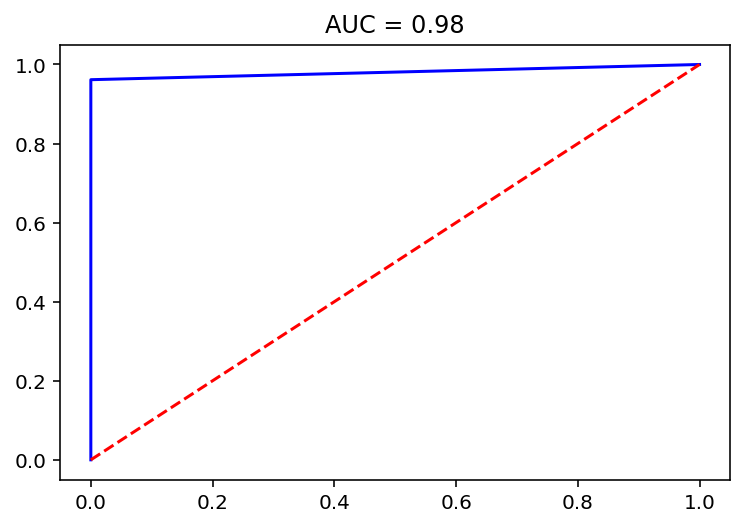

In [12]:
# Medición del rendimiento de los modelos; exactitud, exhaustividad, F1, Auc y matriz de confusión.
print("Random Forest Classifier with Pasting Training Score: ", bag.score(X_train_nm, y_train_nm))
print("Random Forest Classifier with Pasting Testing Score: ", bag.score(X_test_nm, y_test_nm))

y_test_pred = bag.predict(X_test_nm)
y_train_pred = bag.predict(X_train_nm)
cm = confusion_matrix(y_test_nm, y_test_pred)
false_positive_rate, recall, thresholds = roc_curve(y_test_nm, y_test_pred) # el area bajo la curva
roc_auc = auc(false_positive_rate, recall)
    
print("- Nombre del Modelo: {} \n" .format(rf.__class__.__name__) , "\n - Precisión: {} |" 
        .format(accuracy_score(y_test_nm, y_test_pred)), 
        "\n - Exactitud: {} |" .format(precision_score(y_test_nm, y_test_pred)), 
        "\n - Exhaustividad: {} |" .format(recall_score(y_test_nm, y_test_pred)), 
        "\n - F1: {} |" .format(f1_score(y_test_nm, y_test_pred)), 
        "\n - AUC: {} |\n" .format(auc(false_positive_rate, recall)),
        "\n - Matriz de confusion: \n {} \n" .format(cm))
    
plot(false_positive_rate, recall, 'b') # imprimir el ratio
plot([0, 1], [0, 1], 'r--') # difinir el ratio entre 0 y 1
title('AUC = %0.2f' % roc_auc)

In [13]:
# Guardamos la Medición del rendimiento de los modelos en una tabla.
report_table_3 = ['Random Forest with Pasting NM PCA', rf_grid.best_params_,
                  bag.score(X_train_nm, y_train_nm), bag.score(X_test_nm, y_test_nm), recall_score(y_test_nm, y_test_pred),
                 f1_score(y_test_nm, y_test_pred), auc(false_positive_rate, recall)]

##### Logistic Regression with Pasting

In [14]:
lr = LogisticRegression()# l1 lasso l2 ridge)

#model param
param = dict(penalty = ["l1","l2"], C= np.logspace(-3,3,7))# l1 lasso l2 ridge
#grid model
lr_grid = GridSearchCV(lr, param, cv = 2, n_jobs = -1, return_train_score= True)

#train grid model
lr_grid.fit(X_train_nm, y_train_nm)

GridSearchCV(cv=2, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             return_train_score=True)

In [15]:
# Mejores parámetros
print("Best Parameters for Bagging Classifier with Pasting: ", lr_grid.best_params_)

Best Parameters for Bagging Classifier with Pasting:  {'C': 0.001, 'penalty': 'l2'}


In [16]:
# Construcción del modelo 
lr =LogisticRegression(penalty= lr_grid.best_params_['penalty']
                        , C=lr_grid.best_params_['C'])
bag = BaggingClassifier(lr)

grid_param = dict(max_samples=[0.1, 0.5, 0.7, 0.9, 1.0],
                  n_estimators= [100,250, 500, 1000])

#grid model
bag_lr_grid = GridSearchCV(bag, grid_param, cv = 2, n_jobs = -1, return_train_score= True)

#train grid model
bag_lr_grid.fit(X_train_nm, y_train_nm)

GridSearchCV(cv=2,
             estimator=BaggingClassifier(base_estimator=LogisticRegression(C=0.001)),
             n_jobs=-1,
             param_grid={'max_samples': [0.1, 0.5, 0.7, 0.9, 1.0],
                         'n_estimators': [100, 250, 500, 1000]},
             return_train_score=True)

In [17]:
# Mejores parámetros
print("Best Parameters for Bagging Classifier with Pasting: ", bag_lr_grid.best_params_)

Best Parameters for Bagging Classifier with Pasting:  {'max_samples': 0.1, 'n_estimators': 100}


In [18]:
# Construcción del modelo 

bag = BaggingClassifier(lr, n_estimators= bag_lr_grid.best_params_['n_estimators']
                        , max_samples=bag_lr_grid.best_params_['max_samples']
                        , bootstrap=False) # bootstrap=False Para Pasting

bag.fit(X_train_nm, y_train_nm)

BaggingClassifier(base_estimator=LogisticRegression(C=0.001), bootstrap=False,
                  max_samples=0.1, n_estimators=100)

Logistic Regression with Pasting Training Score:  0.8141592920353983
Logistic Regression with Pasting Testing Score:  0.7346938775510204
- Nombre del Modelo: BaggingClassifier 
 
 - Precisión: 0.7346938775510204 | 
 - Exactitud: 1.0 | 
 - Exhaustividad: 0.5 | 
 - F1: 0.6666666666666666 | 
 - AUC: 0.75 |
 
 - Matriz de confusion: 
 [[23  0]
 [13 13]] 



Text(0.5, 1.0, 'AUC = 0.75')

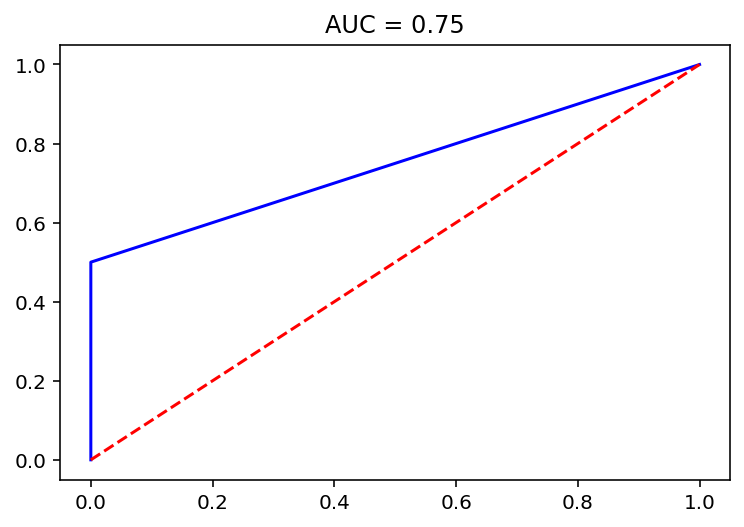

In [19]:
# Medición del rendimiento de los modelos; exactitud, exhaustividad, F1, Auc y matriz de confusión.
print("Logistic Regression with Pasting Training Score: ", bag.score(X_train_nm, y_train_nm))
print("Logistic Regression with Pasting Testing Score: ", bag.score(X_test_nm, y_test_nm))

y_test_pred = bag.predict(X_test_nm)
y_train_pred = bag.predict(X_train_nm)
cm = confusion_matrix(y_test_nm, y_test_pred)
false_positive_rate, recall, thresholds = roc_curve(y_test_nm, y_test_pred) # el area bajo la curva
roc_auc = auc(false_positive_rate, recall)
    
print("- Nombre del Modelo: {} \n" .format(bag.__class__.__name__) , "\n - Precisión: {} |" 
        .format(accuracy_score(y_test_nm, y_test_pred)), 
        "\n - Exactitud: {} |" .format(precision_score(y_test_nm, y_test_pred)), 
        "\n - Exhaustividad: {} |" .format(recall_score(y_test_nm, y_test_pred)), 
        "\n - F1: {} |" .format(f1_score(y_test_nm, y_test_pred)), 
        "\n - AUC: {} |\n" .format(auc(false_positive_rate, recall)),
        "\n - Matriz de confusion: \n {} \n" .format(cm))
    
plot(false_positive_rate, recall, 'b') # imprimir el ratio
plot([0, 1], [0, 1], 'r--') # difinir el ratio entre 0 y 1
title('AUC = %0.2f' % roc_auc)

In [20]:
# Guardamos la Medición del rendimiento de los modelos en una tabla.
report_table_1 = ['Logistic Regression with Pasting NM PCA', lr_grid.best_params_,
                  bag.score(X_train_nm, y_train_nm), bag.score(X_test_nm, y_test_nm), recall_score(y_test_nm, y_test_pred),
                 f1_score(y_test_nm, y_test_pred), auc(false_positive_rate, recall)]

##### Decision Tree with Pasting

En los árboles de decisión se construyen diagramas de construcciones lógicas, muy similares a los sistemas de predicción basados en reglas, que sirven para representar y categorizar una serie de condiciones que ocurren de forma sucesiva, para la resolución de un problema.

In [21]:
# Selección del parámetro “max_depth” de DT con la función "GridSearchCV"
dt = DecisionTreeClassifier()
grid_param = dict(criterion=['gini','entropy'],max_depth= np.arange(1, 15))

dt_grid = GridSearchCV(dt, grid_param, cv = 2, n_jobs = -1)
dt_grid.fit(X_train_nm, y_train_nm)

GridSearchCV(cv=2, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])})

In [22]:
# Mejor parámetro
print("Best Parameters for Decision Tree Classifier: ", dt_grid.best_params_)

Best Parameters for Decision Tree Classifier:  {'criterion': 'gini', 'max_depth': 2}


In [23]:
# Selección de los parámetros 'n_estimators' y 'learning_rate' de DT con la función "GridSearchCV"

dt = DecisionTreeClassifier(max_depth= dt_grid.best_params_['max_depth']
                                ,criterion= dt_grid.best_params_['criterion'])

bag = BaggingClassifier(dt)
#model param
grid_param = dict()
#grid model
bag_dt_grid = GridSearchCV(bag, grid_param, cv = 2, n_jobs = -1, return_train_score= True)

#train grid model
bag_dt_grid.fit(X_train_nm, y_train_nm)

GridSearchCV(cv=2,
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=2)),
             n_jobs=-1, param_grid={}, return_train_score=True)

In [24]:
# Mejores parámetros
print("Best Parameters for Bagging Classifier with Pasting: ", bag_dt_grid.best_params_)

Best Parameters for Bagging Classifier with Pasting:  {}


In [25]:
# Construcción del modelo 
bag = BaggingClassifier(dt,bootstrap=False) # bootstrap=False Para Pasting

bag.fit(X_train_nm, y_train_nm)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                  bootstrap=False)

Decision Tree Classifier with Pasting Training Score:  0.9734513274336283
Decision Tree Classifier with Pasting Testing Score:  0.9591836734693877
- Nombre del Modelo: DecisionTreeClassifier 
 
 - Precisión: 0.9591836734693877 | 
 - Exactitud: 1.0 | 
 - Exhaustividad: 0.9230769230769231 | 
 - F1: 0.9600000000000001 | 
 - AUC: 0.9615384615384616 |
 
 - Matriz de confusion: 
 [[23  0]
 [ 2 24]] 



Text(0.5, 1.0, 'AUC = 0.96')

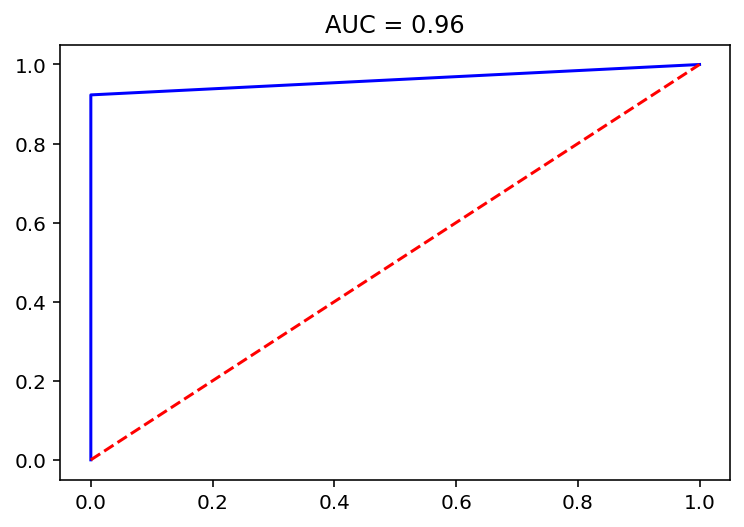

In [26]:
# Medición del rendimiento de los modelos; exactitud, exhaustividad, F1, Auc y matriz de confusión.
print("Decision Tree Classifier with Pasting Training Score: ", bag.score(X_train_nm, y_train_nm))
print("Decision Tree Classifier with Pasting Testing Score: ", bag.score(X_test_nm, y_test_nm))

y_test_pred = bag.predict(X_test_nm)
y_train_pred = bag.predict(X_train_nm)
cm = confusion_matrix(y_test_nm, y_test_pred)
false_positive_rate, recall, thresholds = roc_curve(y_test_nm, y_test_pred) # el area bajo la curva
roc_auc = auc(false_positive_rate, recall)
    
print("- Nombre del Modelo: {} \n" .format(dt.__class__.__name__) , "\n - Precisión: {} |" 
        .format(accuracy_score(y_test_nm, y_test_pred)), 
        "\n - Exactitud: {} |" .format(precision_score(y_test_nm, y_test_pred)), 
        "\n - Exhaustividad: {} |" .format(recall_score(y_test_nm, y_test_pred)), 
        "\n - F1: {} |" .format(f1_score(y_test_nm, y_test_pred)), 
        "\n - AUC: {} |\n" .format(auc(false_positive_rate, recall)),
        "\n - Matriz de confusion: \n {} \n" .format(cm))
    
plot(false_positive_rate, recall, 'b') # imprimir el ratio
plot([0, 1], [0, 1], 'r--') # difinir el ratio entre 0 y 1
title('AUC = %0.2f' % roc_auc)

In [27]:
# Guardamos la Medición del rendimiento de los modelos en una tabla.
report_table_2 = ['Decision Tree Classifier with Pasting NM PCA', dt_grid.best_params_,
                  bag.score(X_train_nm, y_train_nm), bag.score(X_test_nm, y_test_nm), recall_score(y_test_nm, y_test_pred),
                 f1_score(y_test_nm, y_test_pred), auc(false_positive_rate, recall)]

In [28]:
# Mostrar la Medición del rendimiento de los modelos en una tabla.
report_table = pd.DataFrame(list(zip(report_table_1,
             report_table_2, report_table_3))).transpose()

In [29]:
report_table.columns = ['Model Name', 'Model Parameter', 'Training Score', 'Testing Score', "Exhaustividad", "F1", "AUC"]
report_table.index = report_table['Model Name']
report_table.head(15)

,Model Name,Model Parameter,Training Score,Testing Score,Exhaustividad,F1,AUC
Model Name,,,,,,,
Logistic Regression with Pasting NM PCA,Logistic Regression with Pasting NM PCA,"{'C': 0.001, 'penalty': 'l2'}",0.814159,0.734694,0.5,0.666667,0.75
Decision Tree Classifier with Pasting NM PCA,Decision Tree Classifier with Pasting NM PCA,"{'criterion': 'gini', 'max_depth': 2}",0.973451,0.959184,0.923077,0.96,0.961538
Random Forest with Pasting NM PCA,Random Forest with Pasting NM PCA,"{'criterion': 'gini', 'max_depth': 3, 'n_estim...",0.973451,0.979592,0.961538,0.980392,0.980769


In [30]:
# guardamos los resultados
report_table.to_csv('Pasting With NearMiss PCA.csv')

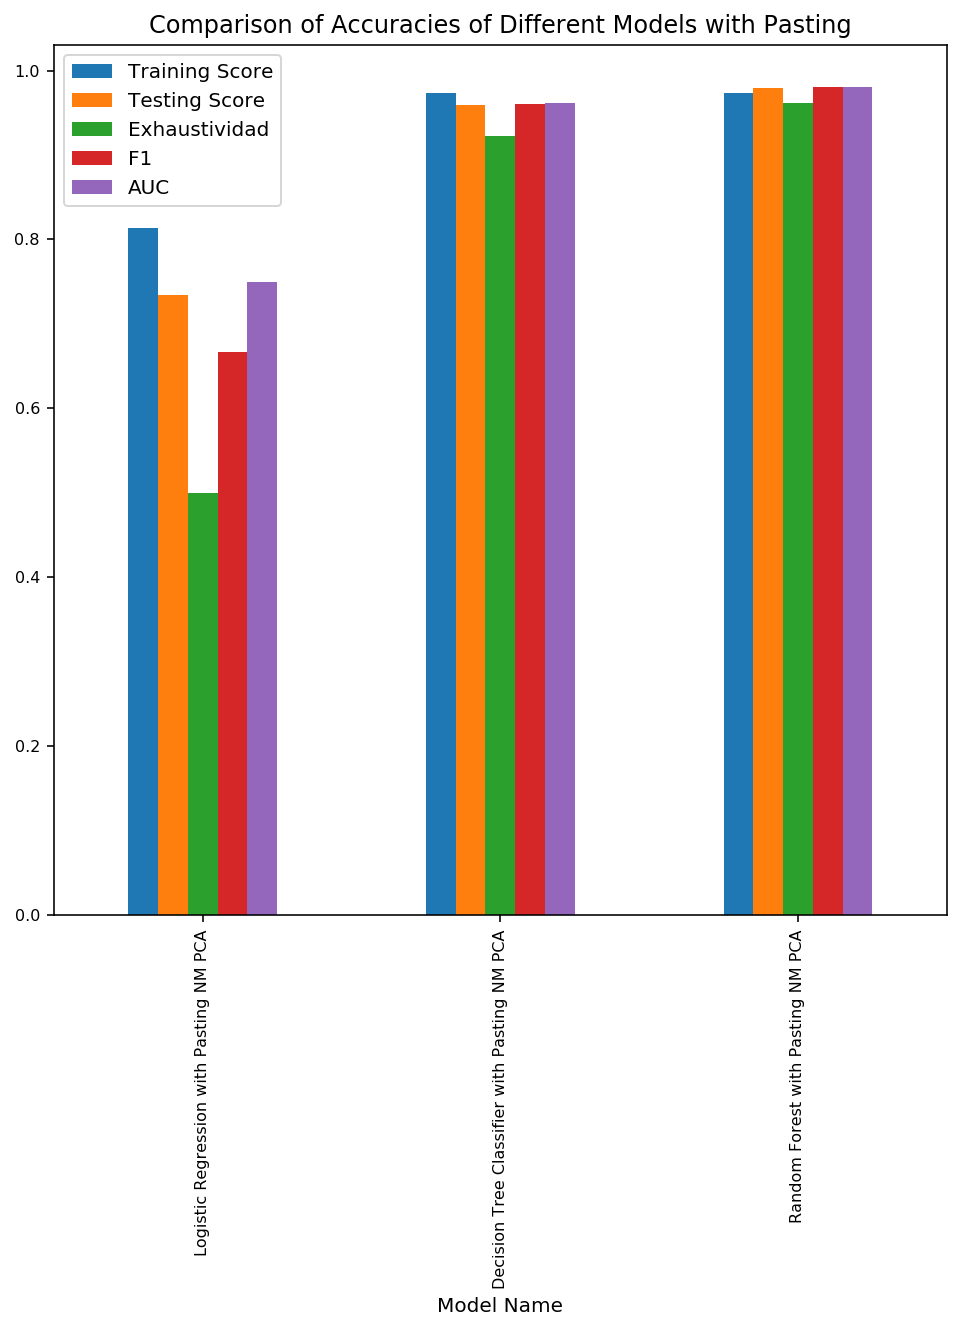

In [31]:
ax = report_table[['Model Name', 'Model Parameter', 'Training Score', 'Testing Score', "Exhaustividad", "F1", "AUC"]].plot(kind='bar',
            title = "Comparison of Accuracies of Different Models with Pasting", figsize=(8, 8), fontsize = 8)
plt.show()